<a href="https://colab.research.google.com/github/roshankenia/RANSAC/blob/main/RANSAC_v2_Identifier_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import OS
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"   #(xxxx is your specific GPU ID)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import random
import numpy as np

from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2D, GlobalMaxPooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler

In [ ]:
#method to add noisy labels to data
def corruptData(trainY, testY, noisePercentage):
  #create copies of labels
  copyTrainY = trainY.copy()
  copyTestY = testY.copy()

  #calculate number of samples to be made noisy
  numberNoisyTrain = int(noisePercentage * len(copyTrainY))
  numberNoisyTest = int(noisePercentage * len(copyTestY))

  #generate indexes to swap
  trainYSwitchIndexes = random.sample(range(0, len(copyTrainY)), numberNoisyTrain)
  testYSwitchIndexes = random.sample(range(0, len(copyTestY)), numberNoisyTest)

  #generate new classes not equal to original for training and switch class
  for i in range(len(trainYSwitchIndexes)):
    label = random.choice(range(10))
    #find label that isn't the same
    while label == trainY[trainYSwitchIndexes[i]]:
      label = random.choice(range(10))
    #switch label
    copyTrainY[trainYSwitchIndexes[i]] = label

  #generate new classes not equal to original for testing and switch class
  for i in range(len(testYSwitchIndexes)):
    label = random.choice(range(10))
    #find label that isn't the same
    while label == testY[testYSwitchIndexes[i]]:
      label = random.choice(range(10))
    #switch label
    copyTestY[testYSwitchIndexes[i]] = label

  return (copyTrainY, copyTestY)

In [ ]:
def splitTrainingData(trainX, trainY, splitPercentage):
  #get number of elements to split
  numberSplit = int(splitPercentage * len(trainX))
  #generate indexes to split
  indexes = list(range(len(trainX)))
  beforeSplitIndexes = random.sample(range(0, len(trainX)), numberSplit)
  afterSplitIndexes = list(set(indexes)-set(beforeSplitIndexes))

  #make new arrays
  firstTrainX = []
  firstTrainY = []
  secondTrainX = []
  secondTrainY = []

  #add each data sample to corresponding list
  for index in beforeSplitIndexes:
    firstTrainX.append(trainX[index])
    firstTrainY.append(trainY[index])
  for index in afterSplitIndexes:
    secondTrainX.append(trainX[index])
    secondTrainY.append(trainY[index])      
  return np.array(firstTrainX), np.array(firstTrainY), np.array(secondTrainX), np.array(secondTrainY), beforeSplitIndexes, afterSplitIndexes

In [ ]:
def trainModel(trainX, trainY, n):
  #pre-train the model

  # number of classes
  K = 10

  # calculate total number of classes
  # for output layer
  print("number of classes:", K)

  # Build the model using the functional API
  # input layer
  i = Input(shape=trainX[0].shape)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)

  if n == 2:
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

  if n == 3:
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.2)(x)

  # Hidden layer
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)

  # last hidden layer i.e.. output layer
  x = Dense(K, activation='softmax')(x)

  model = Model(i, x)

  # model description
  # model.summary()

  # Compile
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Fit
  r = model.fit(trainX, trainY, epochs=20)

  return model

In [ ]:
from scipy.stats import entropy
def makeConfidentTrainingSets(model, firstTrainX, firstTrainY, secondTrainX, secondTrainY, perEntropy, perPeak, beforeSplitIndexes, afterSplitIndexes):
  newTrainX=[]
  newTrainY=[]
  confidentIndexes = []
  #find confident samples from first training set
  #obtain probability distribution of classes for each sample after the split and calculate its entropy
  #make predictions
  firstTrainXPredictions = model.predict(firstTrainX)
  #find entropy and peak value for every sample
  firstTrainXEntropies = []
  firstTrainXPeakValues = []
  for sample in firstTrainXPredictions:
    #calculate entropy
    sampleEntropy = entropy(sample)
    #calculate peak value
    probSorted = sorted(sample)
    peakValue = probSorted[0]/probSorted[1]

    firstTrainXEntropies.append(sampleEntropy)
    firstTrainXPeakValues.append(peakValue)

  #set NANs to 0
  firstTrainXPeakValues = np.array(firstTrainXPeakValues)
  firstTrainXPeakValues[np.isnan(firstTrainXPeakValues)] = 0
  #calculate mean of entropy and peak value
  meanEntropy = np.mean(firstTrainXEntropies)
  meanPeakValue = np.mean(firstTrainXPeakValues)

  #entropy and peak value hyperparameter
  entropyVal = perEntropy*meanEntropy
  peakVal = perPeak*meanPeakValue

  #obtain samples that were correctly predicted and fall under the threshold for entropy and peak value
  for i in range(len(firstTrainXPredictions)):
    probDist = firstTrainXPredictions[i]
    predictedClass = np.argmax(probDist)

    #if confident add to list
    if predictedClass == firstTrainY[i] and firstTrainXEntropies[i] <= entropyVal and firstTrainXPeakValues[i] > peakVal:
      newTrainX.append(firstTrainX[i])
      newTrainY.append(firstTrainY[i])
      confidentIndexes.append(beforeSplitIndexes[i])



  #find confident samples from unused training set
  #obtain probability distribution of classes for each sample after the split and calculate its entropy
  #make predictions
  secondTrainXPredictions = model.predict(secondTrainX)
  #find entropy and peak value for every sample
  secondTrainXEntropies = []
  secondTrainXPeakValues = []
  for sample in secondTrainXPredictions:
    #calculate entropy
    sampleEntropy = entropy(sample)
    #calculate peak value
    probSorted = sorted(sample)
    peakValue = probSorted[0]/probSorted[1]

    secondTrainXEntropies.append(sampleEntropy)
    secondTrainXPeakValues.append(peakValue)

  #set NANs to 0
  secondTrainXPeakValues = np.array(secondTrainXPeakValues)
  secondTrainXPeakValues[np.isnan(secondTrainXPeakValues)] = 0

  #calculate mean of entropy and peak value
  meanEntropy = np.mean(secondTrainXEntropies)
  meanPeakValue = np.mean(secondTrainXPeakValues)

  #entropy and peak value hyperparameter
  entropyVal = perEntropy*meanEntropy
  peakVal = perPeak*meanPeakValue

  #obtain samples that were correctly predicted and fall under the threshold for entropy and peak value
  for i in range(len(secondTrainXPredictions)):
    probDist = secondTrainXPredictions[i]
    predictedClass = np.argmax(probDist)

    #if confident add to list
    if predictedClass == secondTrainY[i] and secondTrainXEntropies[i] <= entropyVal and secondTrainXPeakValues[i] > peakVal:
      newTrainX.append(secondTrainX[i])
      newTrainY.append(secondTrainY[i])
      confidentIndexes.append(afterSplitIndexes[i])

  return newTrainX, newTrainY, confidentIndexes

In [ ]:
#find out how much of corrupted test data the model can correctly predict
def accuracyWithMislabeled(ransac_model, testX, testY, testYMislabeled):
  predictions = ransac_model.predict(testX)
  correctlyPredicted = 0
  normalCount = 0
  correctlyIdentified = 0
  corruptedCount = 0
  for i in range(len(testY)):
    #obtain prediction
    prediction = np.argmax(predictions[i])

    #check if not corrupted and correctly predicted
    if testYMislabeled[i] == testY[i]:
      normalCount+=1
      if prediction == testY[i]:
        correctlyPredicted += 1
    #check if corruped and correctly identified
    elif testYMislabeled[i] != testY[i]:
      corruptedCount += 1
      if prediction == testY[i]:
        correctlyIdentified +=1

  return correctlyPredicted, normalCount, correctlyIdentified, corruptedCount

In [ ]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

#Normalize pixel values to be between 0 and 1
trainX, testX = trainX / 255.0, testX / 255.0

#flatten the label values
trainY, testY = trainY.flatten(), testY.flatten()

#corrupt data
noisePercentage = 0.25
trainYMislabeled, testYMislabeled = corruptData(trainY, testY, noisePercentage)



170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
cleanModel = load_model('/CleanModelTraining/ransac_clean.h5')
upperBoundAccuracy = cleanModel.evaluate(testX, testY)[1]

print(upperBoundAccuracy)

313/313 [==============================] - 2s 6ms/step - loss: 1.5540 - accuracy: 0.6776
0.6776000261306763


In [ ]:
#collect best indexes over multiple models
bestIndexes = list(range(len(trainX)))
for i in range(5):
  #split data
  splitPercentage = .7
  firstTrainX, firstTrainY, secondTrainX, secondTrainY, beforeSplitIndexes, afterSplitIndexes = splitTrainingData(trainX, trainYMislabeled, splitPercentage)

  #train model used to identify confident samples
  confidenceModel = trainModel(firstTrainX, firstTrainY, 1)
  percentageOfEntropy = [0.5,1,2,3]
  percentageOfPeak = [2,1.5,1,.5]
  for j in range(len(percentageOfEntropy)):
    perEntropy = percentageOfEntropy[j]
    perPeak = percentageOfPeak[j]
    
    #find samples that this model is confident on
    newTrainX, newTrainY, confidentIndexes = makeConfidentTrainingSets(confidenceModel, firstTrainX, firstTrainY, secondTrainX, secondTrainY, perEntropy, perPeak, beforeSplitIndexes, afterSplitIndexes)

    #add 1 to every confident image
    for index in confidentIndexes:
      bestIndexes[index]+=1

In [ ]:
#make new datasets for the most confident samples
bestTrainX=[]
bestTrainY=[]

#sort and preserve index
bestSorted = np.argsort(bestIndexes)

#calculate number of samples to user
numberCertain = int(0.5 * len(bestIndexes))

#take certain samples
for i in range(numberCertain):
  bestTrainX.append(trainX[bestSorted[i]])
  bestTrainY.append(trainYMislabeled[bestSorted[i]])

In [ ]:
#run experiments
#train a new model on these confident samples
ransacModel = trainModel(bestTrainX, bestTrainY, 1)

#calculate accuracy of this model in identifying corrupted samples
correctlyPredicted, normalCount, correctlyIdentified, corruptedCount = accuracyWithMislabeled(ransacModel, testX, testY, testYMislabeled)

#add performance
modelPerformance = (correctlyPredicted, normalCount, correctlyIdentified, corruptedCount)

number of classes: 10
Epoch 1/20
1094/1094 [==============================] - 14s 12ms/step - loss: 2.1265 - accuracy: 0.3092
Epoch 2/20
1094/1094 [==============================] - 13s 12ms/step - loss: 1.8457 - accuracy: 0.4058
Epoch 3/20
1094/1094 [==============================] - 14s 13ms/step - loss: 1.7522 - accuracy: 0.4491
Epoch 4/20
1094/1094 [==============================] - 13s 12ms/step - loss: 1.6441 - accuracy: 0.4898
Epoch 5/20
1094/1094 [==============================] - 13s 12ms/step - loss: 1.5268 - accuracy: 0.5242
Epoch 6/20
1094/1094 [==============================] - 13s 12ms/step - loss: 1.3909 - accuracy: 0.5676
Epoch 7/20
1094/1094 [==============================] - 13s 12ms/step - loss: 1.2448 - accuracy: 0.6114
Epoch 8/20
1094/1094 [==============================] - 13s 12ms/step - loss: 1.0953 - accuracy: 0.6531
Epoch 9/20
1094/1094 [==============================] - 13s 12ms/step - loss: 0.9657 - accuracy: 0.6917
Epoch 10/20
1094/1094 [===================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in float_scalars
  from ipykernel import kernelapp as app


number of classes: 10
Epoch 1/20
476/476 [==============================] - 6s 12ms/step - loss: 1.9565 - accuracy: 0.4324
Epoch 2/20
476/476 [==============================] - 6s 12ms/step - loss: 1.4213 - accuracy: 0.5553
Epoch 3/20
476/476 [==============================] - 6s 12ms/step - loss: 1.1990 - accuracy: 0.6274
Epoch 4/20
476/476 [==============================] - 6s 12ms/step - loss: 0.9880 - accuracy: 0.6917
Epoch 5/20
476/476 [==============================] - 6s 12ms/step - loss: 0.7533 - accuracy: 0.7615
Epoch 6/20
476/476 [==============================] - 6s 12ms/step - loss: 0.5331 - accuracy: 0.8308
Epoch 7/20
476/476 [==============================] - 6s 12ms/step - loss: 0.4093 - accuracy: 0.8658
Epoch 8/20
476/476 [==============================] - 6s 12ms/step - loss: 0.2920 - accuracy: 0.9045
Epoch 9/20
476/476 [==============================] - 6s 12ms/step - loss: 0.2587 - accuracy: 0.9161
Epoch 10/20
476/476 [==============================] - 6s 12ms/step -

ValueError: ignored


This model used a percentage of mean of: 2
This model was able to correctly predict 5760 samples out of 9000
This model was able to correctly identify 612 mislabeled samples out of 1000
Adding in the correctly identified mislabeled samples this model had an accuracy of 0.6372

This model used a percentage of mean of: 2.25
This model was able to correctly predict 5695 samples out of 9000
This model was able to correctly identify 622 mislabeled samples out of 1000
Adding in the correctly identified mislabeled samples this model had an accuracy of 0.6317

This model used a percentage of mean of: 2.5
This model was able to correctly predict 5827 samples out of 9000
This model was able to correctly identify 633 mislabeled samples out of 1000
Adding in the correctly identified mislabeled samples this model had an accuracy of 0.646

This model used a percentage of mean of: 2.75
This model was able to correctly predict 5834 samples out of 9000
This model was able to correctly identify 627 mis

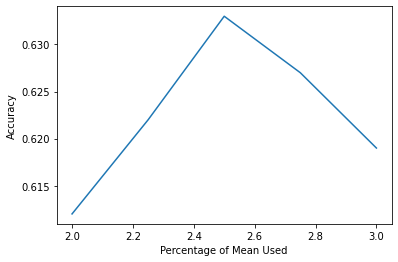

In [ ]:
print("This model was able to correctly predict",modelPerformance[0],"samples out of",modelPerformance[1])
print("This model was able to correctly identify",modelPerformance[2],"mislabeled samples out of",modelPerformance[3])
print("Adding in the correctly identified mislabeled samples this model had an accuracy of",((modelPerformance[0]+modelPerformance[2])/len(testY)))
